In [2]:
import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn 
from torch import optim
#from torchsummary import summary
import random

In [3]:
def create_sequences(data, n_past):
    X,Y = [],[]
    L = len(data)
    for i in range(L-(n_past+5)):
        X.append(data[i:i+n_past])
        Y.append(data[i+n_past:i+n_past+5][:,3])
    
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

In [4]:
df = pd.read_csv('data/2330.TW.csv')
#print(df.shape)
#print(df.head())
def preprocess(data_trend, train_ratio, n_past):
    
    scaler = StandardScaler() 
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend)*train_ratio)
    train_data = data_trend[:train_ind]
    val_data = data_trend[train_ind:]

    # convert our train data into a pytorch tensor
    X_train, Y_train = create_sequences(train_data, n_past)
    X_val, Y_val = create_sequences(val_data, n_past)

    return X_train, Y_train, X_val, Y_val, scaler


In [5]:
class WrappedDataLoader:
    def __init__(self, dataloader, func):
        self.dataloader = dataloader
        self.func = func
        
    def __len__(self):
        return len(self.dataloader)
    
    def __iter__(self):
        iter_dataloader = iter(self.dataloader)
        for batch in iter_dataloader:
            yield self.func(*batch)
            
def transpose(x, y):
    # x and y is [batch size, seq len, feature size]
    # to make them work with default assumption of LSTM,
    # here we transpose the first and second dimension
    # return size = [seq len, batch size, feature size]
    return x.transpose(0, 1), y.transpose(0, 1)

In [6]:
data = df[[c for c in df.columns if c not in ['Date','Adj Close']]].values
X_train, Y_train, X_val, Y_val, scaler = preprocess(data, train_ratio=0.8, n_past=20)

batch_size = 32
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
train_loader = WrappedDataLoader(train_loader, transpose)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
val_loader = WrappedDataLoader(val_loader, transpose)

print('='*10,'Dataset','='*10)
print('X_train->', X_train.shape)
print('Y_train->',Y_train.shape)
print('X_val->  ',X_val.shape)
print('Y_val->  ',Y_val.shape)


========== Dataset ==========
X_train-> torch.Size([945, 20, 5])
Y_train-> torch.Size([945, 5])
X_val->   torch.Size([218, 20, 5])
Y_val->   torch.Size([218, 5])


In [17]:
for inputs, labels in train_loader:
    #print(inputs)
    #print(labels)
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([20, 32, 5])
torch.Size([5, 32])


In [16]:
labels.transpose(0, 1).unsqueeze(0).shape

torch.Size([1, 32, 5])

In [28]:
INPUT_DIM = 5
OUTPUT_DIM = 5
ENC_EMB_DIM = 36
DEC_EMB_DIM = 36
HID_DIM = 128
N_LAYERS = 3
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Seq2Seq(enc, dec, dev).to(dev)
model.load_state_dict(torch.load('/Users/yukaisun/Documents/Research/pytorch學習/saved_models/Seq2Seq/best_seq2seq.pt'))
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(5, 128, num_layers=3)
  )
  (decoder): Decoder(
    (lstm): LSTM(5, 128, num_layers=3)
    (linear): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [30]:
for inputs, labels in val_loader:
    y_pred = model(inputs, labels)
    print(y_pred.shape)
    break

torch.Size([1, 32, 5])


In [ ]:
y_pred

In [34]:
y_pred[:, :, 3]

tensor([[-1.0281, -1.0209, -1.0112, -1.0014, -0.9927, -0.9859, -0.9852, -1.0036,
         -1.0174, -1.0226, -1.0242, -1.0131, -1.0126, -1.0193, -1.0300, -1.0405,
         -1.0505, -1.0583, -1.0703, -1.0823, -1.0932, -1.1018, -1.1103, -1.1132,
         -1.1134, -1.1316, -1.1361, -1.1373, -1.1366, -1.1318, -1.1280, -1.1229]],
       grad_fn=<SelectBackward0>)

In [37]:
labels[3, :]

tensor([-1.0077, -1.0154, -1.0001, -1.0383, -0.9924, -0.9198, -0.9160, -0.9848,
        -0.9618, -1.0192, -1.1148, -1.1568, -1.1377, -1.1607, -1.1683, -1.2142,
        -1.2066, -1.2027, -1.2219, -1.1874, -1.1760, -1.2066, -1.2066, -1.1913,
        -1.1760, -1.1568, -1.1454, -1.1760, -1.2066, -1.2333, -1.2295, -1.2219])

In [48]:
array1.shape

(1, 32)

Text(0, 0.5, 'Value')

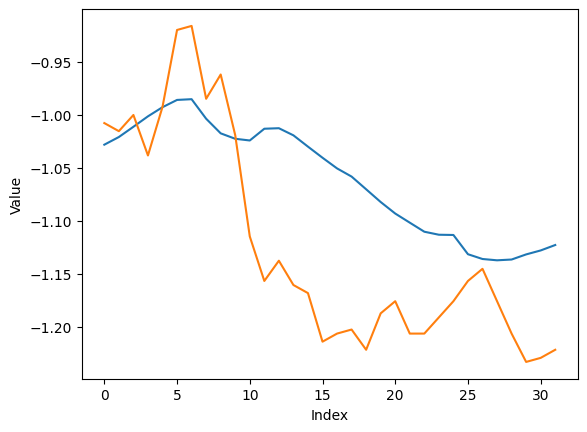

In [49]:
array1 = y_pred[:, :, 3].detach().numpy().reshape(32)
array2 = labels[3, :].detach().numpy()
# 画图
import matplotlib.pyplot as plt

plt.plot(array1, label='Tensor 1')
plt.plot(array2, label='Tensor 2')

# 添加标签和图例
plt.xlabel('Index')
plt.ylabel('Value')
# 显示图像

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_size=5, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.embedding_size = embedding_size

        self.lstm = nn.LSTM(input_size, hidden_size, n_layers)
        
    def forward(self, x):
        # x: input batch data, size: [input_seq_len, batch_size, feature_size]
        _, (hidden, cell) = self.lstm(x)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_size=5, embedding_size=36, hidden_size=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(output_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        """
        x size = [batch_size, feature_size]
        --> x only has two dimensions since the input is batch of last coordinate of observed trajectory
        so the sequence length has been removed.
        """
        # add sequence dimension to x, to allow use of nn.LSTM
        x = x.unsqueeze(0)  # -->[1, batch_size, feature_size]
        
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.linear(output.squeeze(0))

        return prediction, hidden, cell    

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, teacher_forcing_ratio=0.5):
        """
        x = [input_seq_len, batch_size, feature_size]
        y = [target_seq_len, batch_size, feature_size]
        """
        batch_size = x.shape[1]
        y = y.transpose(0, 1).unsqueeze(0)
        target_len = y.shape[0]
        # tensor to store decoder outputs of each time step
        outputs = torch.zeros(target_len, batch_size, self.decoder.output_size).to(self.device) 
        hidden, cell = self.encoder(x)
        decoder_input = x[-1, :, :] # first input to decoder is last of x
        
        for i in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            # place predictions in a tensor holding predictions for each time step

            outputs[i] = output
            
            teacher_forcing = random.random() < teacher_forcing_ratio
            # output is the same shape as decorder input-->[batch_size, feature_size]
            # so we use output directly as input or use true lable depending on teacher_forcing flag
            decoder_input = y[i] if teacher_forcing else output #torch.squeeze(output,0)
        
        return outputs